In [1]:
import xarray as xr
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import regionmask
import shapefile as shp
from math import *
from matplotlib.lines import Line2D
import string
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Latex

In [2]:
# Fonction de moyenne par range d'altitude #

# Note : Le fichier orographie doit avoir les même dim spatial que le ds input

def mean_per_alt(data,ls_range,oro_file,wat = 'arome'): # data : dataset, ls_range : array des altitudes, oro_file : PGD
    ds = []
    ls_range_name = []
    std = []
    nb_points = []
    
    for i in range(0,len(ls_range)-1):
        if wat == 'arome' or wat == 'ALADIN':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('x','y')))
            std.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).std(dim=('x','y')))
        elif wat == 'S2M':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('Number_of_points')))
            std.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).std(dim=('Number_of_points')))

    ds = xr.concat(ds,dim='ZS')
    std = xr.concat(std,dim = 'ZS')
    ds['ZS']  = all_ZS
    std['ZS'] = all_ZS
    return std, ds
####################################################################################

def calc_mean(data,mean_type):

    ds_mean = []
    
    if mean_type == 'month':
        
        num_index = [9,10,11,12,1,2,3,4,5,6,7,8]
        ls_name = ['Sep', 'Oct','Nov', 'Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

        if str(var_name) == all_var[1] or str(var_name)== all_var[2]:
            ds_res = data.resample(time='1MS').sum(skipna = False)
        else: 
            ds_res = data.resample(time='1MS').mean()
    
        for i in range(0,len(num_index)):
            ds_month = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_month = ds_month.groupby('time.year').mean('time')
            ds_mean.append(ds_month)
            
        ds_mean = xr.concat(ds_mean,dim='month')
        ds_mean['month'] = ls_name

    if mean_type == 'season':
        
        num_index = [11,2,5,8]
        ls_name = ['SON','DJF','MAM','JJA']

        if str(var_name) == all_var[1] or str(var_name)== all_var[2]:
            ds_res = data.resample(time='Q-FEB').sum(skipna = False)
        else: 
            ds_res = data.resample(time='Q-FEB').mean()
        
        for i in range(0,len(num_index)):
            ds_season = ds_res.sel(time=ds_res['time.month'] == num_index[i])
            ds_season = ds_season.groupby('time.year').mean('time')
            ds_mean.append(ds_season)
       
        ds_mean = xr.concat(ds_mean,dim='season')
        ds_mean['season'] = ls_name
        
    return ds_mean

####################################################################################

def calc_ratio_ar(data):
    ratio = (data.neige+data.graupel)/(data.accpluie+data.neige+data.graupel)
    return ratio

def calc_ratio_s2m(data):
    return (data.Snowf/(data.Rainf+data.Snowf))

def calc_ratio_aladin(data):
    ratio = (data.prsn)/(data.pr)
    return ratio

def per_alt_per_massif_1(data, style):
    
    data_alt_massif = []
    
    if style == 'S2M':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(file_extra.massif_number==massif_nums2m[i]),ls_range,file_extra.ZS,wat = 'S2M')[1])
    
    elif style == 'arome':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(mask_massif == i), ls_range, oro)[1])

    elif style == 'ALADIN':
        
        for i in range(0,23):
            data_alt_massif.append(mean_per_alt(data.where(mask_massif_ala == i), ls_range, oro_ala)[1])
        
    data_alt_massif = xr.concat(data_alt_massif, dim = 'massif')
    data_alt_massif['massif'] = massif_name

    return data_alt_massif

def agreg_per_alt(data,ls_range,oro_file,wat = 'arome'):
    ds = []
    ls_range_name = []
    std = []
    nb_points = []
    
    for i in range(0,len(ls_range)-1):
        if wat == 'arome' or wat == 'ALADIN':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])))
        elif wat == 'S2M':
            ds.append(data.where((oro_file<ls_range[i+1])*(oro_file>=ls_range[i])).mean(dim=('Number_of_points')))

    ds = xr.concat(ds,dim='ZS')
    ds['ZS']= all_ZS
    return ds


def per_alt_per_massif(data, style):
    
    data_alt_massif = []
    
    if style == 'S2M':
        
        for i in range(0,23):
            data_alt_massif.append(agreg_per_alt(data.where(file_extra.massif_number==massif_nums2m[i]),ls_range,file_extra.ZS,wat = 'S2M'))
        data_alt_massif = xr.concat(data_alt_massif, dim = 'massif')
        data_alt_massif['massif'] = massif_name
    
    elif style == 'arome':
        
        data_alt_massif = agreg_per_alt(data.where(mask_all == True), ls_range, oro)

    elif style == 'ALADIN':
        
        data_alt_massif = agreg_per_alt(data.where(mask_all_ala == True), ls_range, oro_ala)
        

    return data_alt_massif


In [3]:
##################
# INITIALISATION #
##################

data_path_arome = '/home/monteiro/STAGEIENM3/data_AROME/'
data_path_aladin = '/home/monteiro/STAGEIENM3/data_Adamont/'

all_ZS = np.arange(0,5100,300)
ls_range = [0,150,450,750,1050,1350,1650,1950,2250,2550,2850,3150,3450,3750,4050,4350,4750,4900]

massif = geopandas.read_file('/home/monteiro/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')
massif_name=np.array(massif.nom) # Nom des massifs dans l'ordre indice
massif_nums2m = np.array(massif.massif_num) # Numero des massifs dans l'ordre de l'article Arome/Safran
sf = shp.Reader('/home/monteiro/STAGEIENM3/data_S2M/massifs_shapefiles/massifs_alpes_4326.shp')

##########################
# Load mask & topo arome #
##########################

name_oro = 'PGD_setgrid_subset.nc'
oro = xr.open_dataset(data_path_arome+'PGD/'+name_oro)

mask_massif = xr.open_dataset(data_path_arome+'mask_alpes/'+'mask_massif_subset.nc')
mask_massif = mask_massif['__xarray_dataarray_variable__']
mask_massif = mask_massif.rename({'X':'x','Y':'y'})

mask_all = xr.open_dataset(data_path_arome+'mask_alpes/'+'mask_all_subset.nc')
mask_all = mask_all['SFX.AVG_ZS']
mask_all = mask_all.rename({'X':'x','Y':'y'})

oro = oro['SFX.AVG_ZS']
lon = oro.lon[0,:].values
lat = oro.lat[:,0].values
oro = oro.rename({'X':'x','Y':'y'})
oro['y'] = lat
oro['x'] = lon

oro_per_massif = []
for i in range(0,23):
    oro_per_massif.append(oro.where(mask_massif == i))
oro_per_massif = xr.concat(oro_per_massif, dim = 'massif')
oro_per_massif['massif'] = massif_name

file_extra = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/file_extra.nc')

#################
# Load DS arome #
#################

all_var = ['Air temperature at 2m','Total precipitation','Fraction of solid precipitation','Snow depth']
all_unit = [' (°C)',' (kg m$^{-2}$)','',' (m)',]

unit = all_unit[0]
var_name = all_var[0]

run = 'HISTORICAL' #RCP85, HISTORICAL or run_eval/

yr_1 = 1981
yr_2 = 2012

# Load monmean #

def load_arome_mean_ds(var_name):
    
    if var_name == all_var[0]:
        ar_monmean = xr.open_dataset(data_path_arome+'t2m/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.tas-273.15
    if var_name == all_var[1]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/monthly_mean/monmean_all_time.nc').graupel*3600
        ar_monmean_pluie = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/monthly_mean/monmean_all_time.nc').accpluie*3600
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/monthly_mean/monmean_all_time.nc').accneige*3600
        ar_monmean = (ar_monmean_grau + ar_monmean_pluie + ar_monmean_neige)
    if var_name == all_var[2]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/monthly_mean/monmean_all_time.nc').graupel
        ar_monmean = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/monthly_mean/monmean_all_time.nc').accneige
        ar_monmean['graupel'] = ar_monmean_grau
        ar_monmean['neige'] = ar_monmean_neige
        ar_monmean = ar_monmean.drop_vars(('lon_bnds', 'lat_bnds', 'time_bnds'))*3600
    if var_name == all_var[3]:
        ar_monmean = xr.open_dataset(data_path_arome+'snd/'+run+'/monthly_mean/monmean_all_time.nc')
        ar_monmean = ar_monmean.snd
    ar_monmean['y'] = lat
    ar_monmean['x'] = lon
    return ar_monmean

# Load daymean #

def load_arome_daily_mean(var_name):
    if var_name == all_var[0]:
        ar_monmean = xr.open_dataset(data_path_arome+'t2m/'+run+'/daily_mean/daymean_all_time.nc')
        ar_monmean = ar_monmean.tas-273.15
    if var_name == all_var[1]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/daily_mean/daymean_all_time.nc').graupel*3600
        ar_monmean_pluie = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/daily_mean/daymean_all_time.nc').accpluie*3600
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/daily_mean/daymean_all_time.nc').accneige*3600
        ar_monmean = (ar_monmean_grau + ar_monmean_pluie + ar_monmean_neige)
    if var_name == all_var[2]:
        ar_monmean_grau = xr.open_dataset(data_path_arome+'acc_graupel/'+run+'/daily_mean/daymean_all_time.nc').graupel
        ar_monmean = xr.open_dataset(data_path_arome+'acc_pluie/'+run+'/daily_mean/daymean_all_time.nc')
        ar_monmean_neige = xr.open_dataset(data_path_arome+'acc_neige/'+run+'/daily_mean/daymean_all_time.nc').accneige
        ar_monmean['graupel'] = ar_monmean_grau
        ar_monmean['neige'] = ar_monmean_neige
        ar_monmean = ar_monmean.drop_vars(('lon_bnds', 'lat_bnds', 'time_bnds'))*3600
    if var_name == all_var[3]:
        ar_monmean = xr.open_dataset(data_path_arome+'snd/'+run+'daily_mean/daymean_all_time.nc')
        ar_monmean = ar_monmean.snd
    ar_monmean['y'] = lat
    ar_monmean['x'] = lon
    return ar_monmean

####################
# Load DS Aladin   #
####################
# Hiver 1996/1997 se situe en 1997

def load_Adam_ds(var_name):
        
    if var_name == all_var[0]:
        data = xr.open_dataset(data_path_aladin+run+'/meteo_adamont_'+run+'.nc')
        data = data.Tair-273.15
 
    elif var_name == all_var[1]:
        data = xr.open_dataset(data_path_aladin+run+'/meteo_adamont_'+run+'.nc')
        data = (data.Rainf+data.Snowf)*3600
        
    elif var_name == all_var[2]:
        data = xr.open_dataset(data_path_aladin+run+'/meteo_adamont_'+run+'.nc')
        data = (data*3600)
        
    elif var_name == all_var[3]:
        data = xr.open_dataset(data_path_aladin+run+'/pro_adamont_'+run+'.nc')
        data = data.DSN_T_ISBA
        
    return data

#################
# Load DS S2M   #
#################

def load_ds_s2m(var_name):
    
    if var_name == all_var[0]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/Tair_1958_2018.nc')
        data = data.Tair-273.15
 
    elif var_name == all_var[1]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/Rainf_Snowf_1958_2018.nc')
        data = (data.Rainf+data.Snowf)*3600
        
    elif var_name == all_var[2]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/Rainf_Snowf_1958_2018.nc')
        data = (data*3600)
        
    elif var_name == all_var[3]:
        data = xr.open_dataset('/home/monteiro/STAGEIENM3/data_S2M/alp_flat/snow_1958_2018.nc')
        data = data.DSN_T_ISBA

    return data

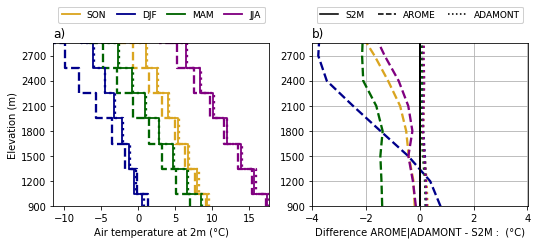

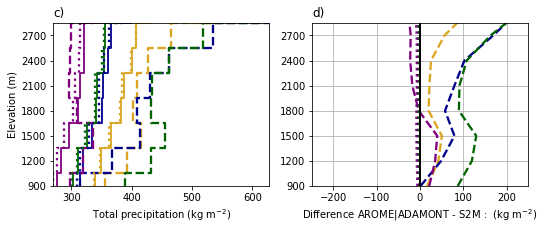

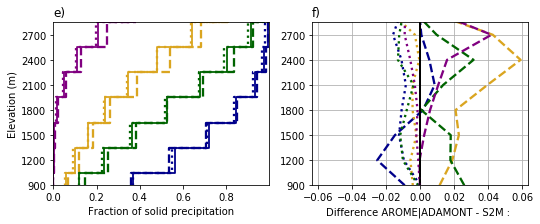

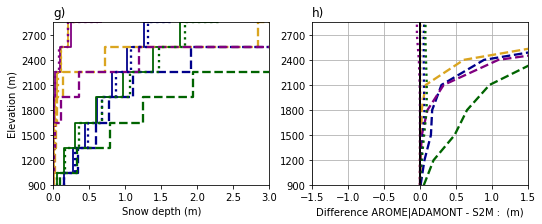

In [15]:
########################
# PROFILS ALTITUDINAUX #
########################

# Pour le resample par saison on enleve la premiere et la derniere année : 1er année car DJF se retrouve à la fin de la saison et est donc incomplet
# la derniere année de la meme façon car il va jusqu'a l'année n+1 en prenant juste décembre, les donnée vont donc de 1988 à 2018, inclus

# Mettre toujours en premier dans data le dataset qui sera comparé aux autres dans les différences (S2M)
pp = PdfPages('/home/monteiro/Bureau/Rapport STAGE IENM3/profil_altitudinaux.pdf')

linestyle = ['-','--', ':']
color = ['goldenrod','darkblue','darkgreen','purple']
linewidth = ['1.8','2.3','2.3']
letter = [['a)','b)'],['c)','d)'],['e)','f)'],['g)','h)']]


for k in range(0,len(all_var)):
    unit = all_unit[k]
    var_name = all_var[k]
    run = 'run_eval' #RCP85, HISTORICAL or run_eval/
    yr_1 = 1981
    yr_2 = 2012

    if var_name == all_var[2]:
        mask_ar = calc_ratio_ar(per_alt_per_massif_1(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        ar_season = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        s2m_season = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar)))
        adam_season = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar)))
    else:
        mask_ar = per_alt_per_massif_1(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2))
        ar_season = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2))
        s2m_season = per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar))
        adam_season = per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar))

    #########################################################

    borne_alt = [900,3000]

    fig, ax = plt.subplots(1,2,figsize=(8.5,3))

    ds_lim = []
    data = [s2m_season.mean(dim = 'massif'), ar_season.mean(dim = ('x','y')), adam_season.mean(dim = 'massif')]

    for j in range(0,3):
        x = data[j]
        x = x.sel(ZS = slice(borne_alt[0],borne_alt[1]))
        x_mean, x_std = x.mean(dim='year'), x.std(dim = 'year')

        for i in range(0,len(x.season)):
            ax[0].step(x_mean.sel(season = x.season[i]),x.ZS-150, where='pre', linestyle = linestyle[j],linewidth=linewidth[j], color = color[i])
            ax[0].set_ylabel('Elevation (m)')
            ax[0].set_xlabel(var_name+unit)
            ax[0].set_yticks(x.ZS)
            ax[0].set_title(letter[k][0] , loc = 'left')

        ds_lim.append(x_mean)
    if k == 0:
        lines = ax[0].get_lines()
        legend1 = ax[1].legend([Line2D([0],[0],color = 'k', linestyle = linestyle[0]),Line2D([0],[0],color = 'k', linestyle = linestyle[1]),Line2D([0],[0],color = 'k', linestyle = linestyle[2])], ['S2M', 'AROME', 'ADAMONT'],mode = 'expand',ncol = 3,bbox_to_anchor=(0., 1.15, 1., .102), prop={'size': 9})
        legend2 = ax[0].legend([lines[k] for k in [0,1,2,3]], ['SON','DJF','MAM','JJA'],mode = 'expand',ncol = 4,bbox_to_anchor=(0., 1.15, 1., .102), prop={'size': 9})
        ax[1].add_artist(legend1)
        ax[0].add_artist(legend2)
    ax[0].set_ylim(borne_alt[0],borne_alt[1]-150)
    ax[0].set_xlim(np.nanmin(ds_lim),np.nanmax(ds_lim))

    for j in range(1,len(data)):

        diff = data[j].mean(dim = 'year').sel(ZS = slice(borne_alt[0],borne_alt[1])) - data[0].mean(dim = 'year').sel(ZS = slice(borne_alt[0],borne_alt[1]))

        for i in range(0,len(diff.season)):
            ax[1].plot(diff.sel(season = diff.season[i]),diff.ZS,linestyle = linestyle[j], linewidth = linewidth[j], color = color[i])
            ax[1].plot([0]*len(diff.ZS), diff.ZS, linestyle = '-', color = 'k')
            ax[1].set_yticks(diff.ZS)
            ax[1].set_xlabel('Difference AROME|ADAMONT - S2M : '+unit)
            ax[1].set_ylim(borne_alt[0],borne_alt[1]-150)
            ax[1].set_title(letter[k][1] , loc = 'left')

    # set dynamical xlim #
    xlim = plt.xlim()
    max_xlim = max(map(abs, xlim))
    plt.xlim((-max_xlim, max_xlim))
    ######################
    if k == 3:
        ax[0].set_xlim(0,3)
        ax[1].set_xlim(-1.5,1.5)

    plt.grid()
#     plt.tight_layout()
    plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()

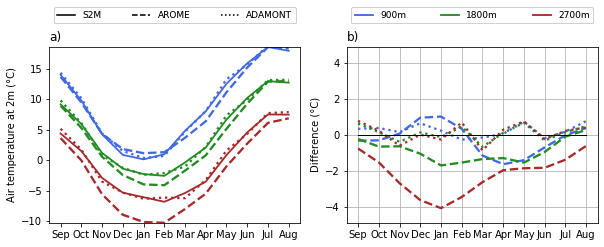

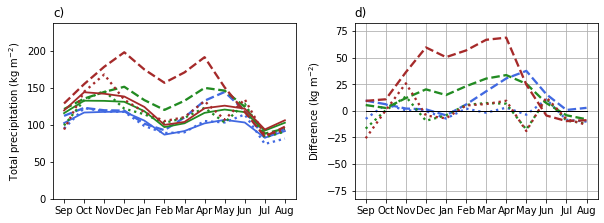

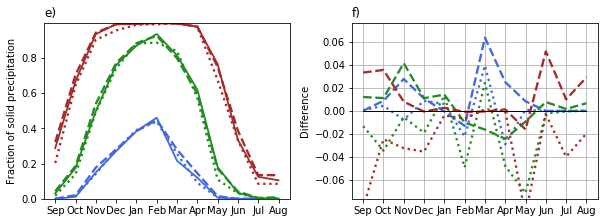

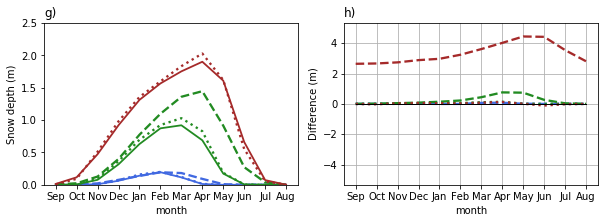

In [16]:
#############################
# Evolutions mensuelles all #
#############################

pp = PdfPages('/home/monteiro/Bureau/Rapport STAGE IENM3/distributions_mensuelles.pdf')
letter = [['a)','b)'],['c)','d)'],['e)','f)'],['g)','h)']]
linestyle = ['-','--', ':']
color = ['royalblue','forestgreen', 'brown']
linewidth = ['1.8','2.3','2.3']

for j in range(0,len(all_var)):
    
    unit = all_unit[j]
    var_name = all_var[j]
    run = 'run_eval' #RCP85, HISTORICAL or run_eval/
    yr_1 = 1982
    yr_2 = 2012


    if var_name == all_var[2]:
        mask_ar = calc_ratio_ar(per_alt_per_massif_1(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        ar_month_all = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        s2m_month_all = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar)))
        adam_month_all = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar)))
    else:
        mask_ar = per_alt_per_massif_1(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2))
        ar_month_all = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2))
        s2m_month_all = per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar))
        adam_month_all = per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar))

    fig, ax = plt.subplots(1,2, figsize =(8.5,3.2))

    plot_ZS_range = np.arange(900,3600,900)


################################################# 

    # Define lim difference #
    diff_lim = []
    data_lim = []
    for i in range(0,len(plot_ZS_range)): 

        alt_i = plot_ZS_range[i]
        ar_month = ar_month_all.sel(ZS = alt_i ).mean(dim =('x','y')).mean(dim = 'year')
        s2m_month = s2m_month_all.sel(ZS = alt_i).mean(dim = 'massif').mean(dim = 'year')
        adam_month = adam_month_all.sel(ZS = alt_i).mean(dim = 'massif').mean(dim = 'year')
        diff_lim.append(np.abs(s2m_month - ar_month))
        data_lim.append([s2m_month, ar_month])
    diff_lim = np.nanmax(diff_lim)
    data_lim_inf = np.nanmin(data_lim)
    data_lim_sup = np.nanmax(data_lim)
    
    ######################### 

    for i in range(0,len(plot_ZS_range)):

        alt_i = plot_ZS_range[i]

        ar_month = ar_month_all.sel(ZS = alt_i ).mean(dim =('x','y')).mean(dim = 'year')
        s2m_month = s2m_month_all.sel(ZS = alt_i).mean(dim = 'massif').mean(dim = 'year')
        adam_month = adam_month_all.sel(ZS = alt_i).mean(dim = 'massif').mean(dim = 'year')
        
        ax[0].plot(ar_month.month,ar_month, linestyle = linestyle[1],label = 'AROME',linewidth = linewidth[1] ,color = color[i])
        ax[0].plot(s2m_month.month,s2m_month, linestyle = linestyle[0],label = 'S2M',linewidth = linewidth[0], color = color[i])
        ax[0].plot(adam_month.month,adam_month, linestyle = linestyle[2], label = 'ADAMONT',linewidth = linewidth[2], color = color[i])
        ax[0].set_ylim(data_lim_inf,data_lim_sup)
        ax[0].set_ylabel(var_name+unit)
        ax[0].set_title(letter[j][0] , loc = 'left')

        diff_ar = (ar_month - s2m_month)
        diff_adam = (adam_month - s2m_month)

        ax[1].plot(diff_ar.month,diff_ar,linestyle = linestyle[1] ,linewidth = linewidth[1],color = color[i])
        ax[1].plot(diff_adam.month,diff_adam,linestyle = linestyle[2],linewidth = linewidth[2] ,color = color[i])

        ax[1].plot(diff_ar.month,[0]*len(diff_ar.month), color = 'k',linewidth = 1, linestyle = '-')
        ax[1].set_ylabel('Difference'+unit)
        ax[1].set_ylim((-diff_lim*1.2, diff_lim*1.2))
        ax[1].set_title(letter[j][1] , loc = 'left')
        plt.grid()
        
    if j == 0 :
        lines = ax[0].get_lines()
        legend1 = ax[0].legend([Line2D([0],[0],color = 'k', linestyle = linestyle[0]),Line2D([0],[0],color = 'k', linestyle = linestyle[1]),Line2D([0],[0],color = 'k', linestyle = linestyle[2])], ['S2M','AROME','ADAMONT'], mode = 'expand',ncol = 3,bbox_to_anchor=(0., 1.15, 1., .102), prop={'size': 9})
        legend2 = ax[1].legend([lines[x] for x in [1,4,7]], ['900m','1800m','2700m'], mode = 'expand',ncol = 3,bbox_to_anchor=(0., 1.15, 1., .102), prop={'size': 9})
        ax[0].add_artist(legend1)
        ax[1].add_artist(legend2)
        
    if j == 1:
        ax[0].set_ylim((0, data_lim_sup*1.2))
        
    if j == 3:
        ax[0].set_ylim(0,2.5)
        ax[0].set_xlabel('month')
        ax[1].set_xlabel('month')

#         ax[1].set_ylim(-1,1)
    plt.tight_layout()
    
    plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()

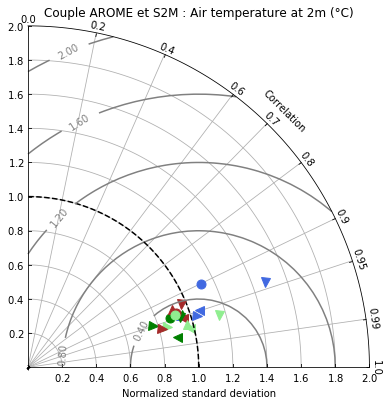

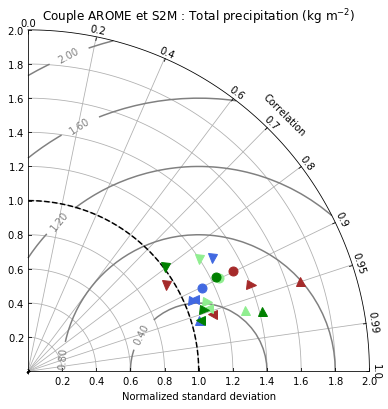

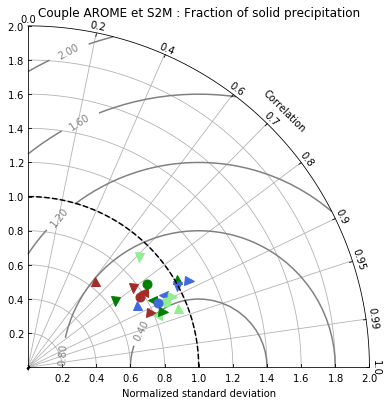

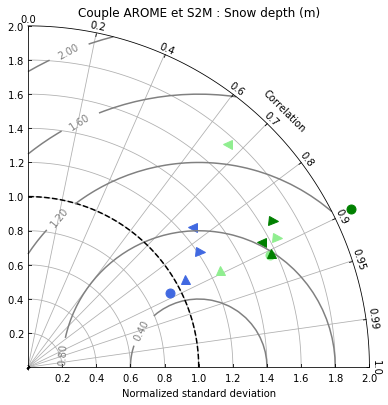

In [5]:
import numpy as NP
import matplotlib.pyplot as PLT
from matplotlib.lines import Line2D

############################## # Lorsqu'il s'agit de la même periode pour les 3/4
# Define variable per season #
##############################

# Ici le ratio est calculé avant de faire la moyenne sur les massifs, cela signifie que le ratio
# est un ratio par massif qui est ensuite moyenné sur l'ensemble des Alpes


class TaylorDiagram(object):

    def __init__(self, refstd,fig=None, rect=111, label='_', srange=(0.01, 2), extend=False):


        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = 1            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = NP.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = NP.pi
            rlocs = NP.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = NP.pi/2
        tlocs = NP.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = PLT.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Normalized standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, '',
                          ls='', ms=10, label=label)
        t = NP.linspace(0, self.tmax)
        r = NP.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):

        l, = self.ax.plot(NP.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = NP.meshgrid(NP.linspace(self.smin, self.smax),
                             NP.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = NP.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*NP.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours


###########################################################
# PLOT #
###########################################################

    
label_season = ['SON','DJF','MAM','JJA','Annual']
colors = ['brown','green','lightgreen','royalblue']
label_alt = ['2700m','2100m','1500m','900m']
markers = ["<","^",">","v",'o']

for k in range(0,4):
    unit = all_unit[k]
    var_name = all_var[k]
    run = 'run_eval' #RCP85, HISTORICAL or run_eval/
    yr_1 = 1981
    yr_2 = 2012

    if var_name == all_var[2]:   
        mask_ar = calc_ratio_ar(per_alt_per_massif_1(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        ar_season = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        s2m_season = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar)))
        adam_season = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar)))
    else:
        mask_ar = per_alt_per_massif_1(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2))
        ar_season = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'season'),style = 'arome').sel(year = slice(yr_1,yr_2))
        s2m_season = per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar))
        adam_season = per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'season'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar))

    if var_name == all_var[2]:    
        mask_ar = calc_ratio_ar(per_alt_per_massif_1(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        ar_month = calc_ratio_ar(per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2)))
        s2m_month = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar)))
        adam_month = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar)))
    else:
        mask_ar = per_alt_per_massif_1(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2))
        ar_month = per_alt_per_massif(calc_mean(load_arome_mean_ds(var_name),'month'),style = 'arome').sel(year = slice(yr_1,yr_2))
        s2m_month = per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar))
        adam_month =  per_alt_per_massif(calc_mean(load_Adam_ds(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)).where(~np.isnan(mask_ar))
    # Taylor diagram #

    fig = PLT.figure(figsize=(10.5, 6.5))
    dia = TaylorDiagram(refstd=1,fig=fig, rect=122)
    ls_alt = [2700,2100,1500,900]

    for j in range(0,len(ar_season.season)):
        for i in range(0,len(ls_alt)):
            ar = ar_season.sel(season = ar_season.season[j], ZS = ls_alt[i]).mean(dim = ('x','y'))
            s2m = s2m_season.sel(season = ar_season.season[j], ZS = ls_alt[i]).mean(dim = 'massif')

            stddev, corrcoef = ar.std(ddof = 1)/s2m.std(ddof=1), np.corrcoef(ar,s2m)[0,1]
            dia.add_sample(stddev, corrcoef,marker=markers[j], ms=9, ls='',color=colors[i],label= label_alt[i]+' '+label_season[j])

    for i in range(0,len(ls_alt)):
        ar = ar_month.mean(dim = ('x','y','month')).sel(ZS = ls_alt[i])
        s2m = s2m_month.mean(dim = ('massif','month')).sel(ZS = ls_alt[i])
        stddev, corrcoef = ar.std(ddof = 1)/s2m.std(ddof=1), np.corrcoef(ar,s2m)[0,1]

        dia.add_sample(stddev, corrcoef,marker=markers[-1], ms=9, ls='',color=colors[i],label= label_alt[i]+' '+label_season[-1])

    # Add grid
    dia.add_grid()
    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

#     lines = ax[0].get_lines()
#     legend1 = fig.legend([Line2D([0],[0],color = colors[0]),Line2D([0],[0],color = colors[1]),Line2D([0],[0],color = colors[2]),Line2D([0],[0],color = colors[3])],['2700m','2100m','1500m','900m'], loc="upper right",bbox_to_anchor=(0.65, 0.9), prop={'size': 8})
#     legend2 = fig.legend([Line2D([0],[0],color = 'k',ls = '', marker = markers[0]),Line2D([0],[0],color = 'k',ls = '', marker = markers[1]),Line2D([0],[0],color = 'k',ls = '', marker = markers[2]),Line2D([0],[0],color = 'k',ls = '', marker = markers[3]),Line2D([0],[0],color = 'k',ls = '', marker = markers[-1])], ['SON','DJF','MAM','JJA','Annual'], loc="upper right",bbox_to_anchor=(0.64, 0.7),prop={'size': 7})
#     fig.add_artist(legend1)
#     fig.add_artist(legend2)

    plt.tight_layout()
    plt.title('Couple AROME et S2M : '+var_name+unit);

    ############################################################################

#     fig = PLT.figure(figsize=(10.5, 6.5))
#     dia = TaylorDiagram(refstd=1,fig=fig, rect=122)
#     ls_alt = [2700,2100,1500,900]

#     for j in range(0,len(ar_season.season)):
#         for i in range(0,len(ls_alt)):
#             adam = adam_season.sel(season = adam_season.season[j], ZS = ls_alt[i]).mean(dim = 'massif')
#             s2m = s2m_season.sel(season = adam_season.season[j], ZS = ls_alt[i]).mean(dim = 'massif')

#             stddev, corrcoef = adam.std(ddof = 1)/s2m.std(ddof=1), np.corrcoef(adam,s2m)[0,1]
#             dia.add_sample(stddev, corrcoef,marker=markers[j], ms=9, ls='',color=colors[i],label= label_alt[i]+' '+label_season[j])

#     for i in range(0,len(ls_alt)):
#         adam = adam_month.mean(dim = ('massif','month')).sel(ZS = ls_alt[i])
#         s2m = s2m_month.mean(dim = ('massif','month')).sel(ZS = ls_alt[i])
#         stddev, corrcoef = adam.std(ddof = 1)/s2m.std(ddof=1), np.corrcoef(adam,s2m)[0,1]

#         dia.add_sample(stddev, corrcoef,marker=markers[-1], ms=9, ls='',color=colors[i],label= label_alt[i]+' '+label_season[-1])


#     # Add grid
#     dia.add_grid()
#     # Add RMS contours, and label them
#     contours = dia.add_contours(colors='0.5')
#     PLT.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

# #     lines = ax[0].get_lines()
# #     legend1 = fig.legend([Line2D([0],[0],color = colors[0]),Line2D([0],[0],color = colors[1]),Line2D([0],[0],color = colors[2]),Line2D([0],[0],color = colors[3])],['2700m','2100m','1500m','900m'], loc="upper right",bbox_to_anchor=(0.51, 0.6), prop={'size': 9})
# #     legend2 = fig.legend([Line2D([0],[0],color = 'k',ls = '', marker = markers[0]),Line2D([0],[0],color = 'k',ls = '', marker = markers[1]),Line2D([0],[0],color = 'k',ls = '', marker = markers[2]),Line2D([0],[0],color = 'k',ls = '', marker = markers[3])], ['SON','DJF','MAM','JJA'], loc="upper right",bbox_to_anchor=(0.51, 0.68),prop={'size': 9})
# #     fig.add_artist(legend1)
# #     fig.add_artist(legend2)
#     plt.tight_layout()
#     plt.title('Couple ADAMONT et S2M : '+var_name+unit);

In [6]:
#####################
# Load daily values #
#####################

unit = all_unit[1]
var_name = all_var[1]
run = 'run_eval'
yr_1 = 1981
yr_2 = 2012

if var_name == all_var[2]:    
    ar_day = calc_ratio_ar(per_alt_per_massif(load_arome_daily_mean(var_name).sel(time = slice(str(yr_1),str(yr_2))).resample(time = '1D').sum(skipna=False),style = 'arome'))
    s2m_day = calc_ratio_s2m(per_alt_per_massif(load_ds_s2m(var_name).sel(time = slice(str(yr_1),str(yr_2))).resample(time = '1D').sum(skipna=False),style = 'S2M').where(~np.isnan(ar_day)))
    adam_day = calc_ratio_s2m(per_alt_per_massif(load_Adam_ds(var_name).sel(time = slice(str(yr_1),str(yr_2))).resample(time = '1D').sum(skipna=False),style = 'S2M').where(~np.isnan(ar_day)))
elif var_name == all_var[1]:
    ar_day = per_alt_per_massif(load_arome_daily_mean(var_name).sel(time = slice(str(yr_1),str(yr_2))).resample(time = '1D').sum(skipna=False),style = 'arome')
    s2m_day = per_alt_per_massif(load_ds_s2m(var_name).sel(time = slice(str(yr_1),str(yr_2))).resample(time = '1D').sum(skipna=False),style = 'S2M').where(~np.isnan(ar_day))
    adam_day = per_alt_per_massif(load_Adam_ds(var_name).sel(time = slice(str(yr_1),str(yr_2))).resample(time = '1D').sum(skipna=False),style = 'S2M').where(~np.isnan(ar_day))
else:
    ar_day = per_alt_per_massif(load_arome_daily_mean(var_name).sel(time = slice(str(yr_1),str(yr_2))).resample(time = '1D').mean(),style = 'arome')
    s2m_day = per_alt_per_massif(load_ds_s2m(var_name).sel(time = slice(str(yr_1),str(yr_2))).resample(time = '1D').mean(),style = 'S2M').where(~np.isnan(ar_day))
    adam_day = per_alt_per_massif(load_Adam_ds(var_name).sel(time = slice(str(yr_1),str(yr_2))).resample(time = '1D').mean(),style = 'S2M').where(~np.isnan(ar_day))

KeyboardInterrupt: 

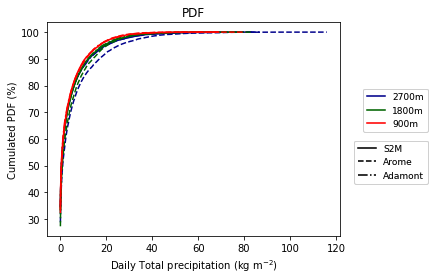

In [13]:
#######
# PDF #
#######

def PDF(data):
    data_marker = ['-','--']
    ds = data
    nb_sample = 2000

    PDF = []
    ds_min, ds_max = np.nanmin(ds), np.nanmax(ds)
    if var_name == all_var[2]:
        ds_min, ds_max = 0, 1
    interval = np.arange(ds_min,ds_max, (ds_max-ds_min)/nb_sample)

    for i in range(0,len(interval)-1):
        PDF.append(ds.where((ds >= interval[i])*(ds <interval[i+1])).count())

    PDF = xr.concat(PDF, dim = 'interval')
    tot = int(PDF.sum().values)

    for i in range(1,len(PDF)):
        PDF_1 = PDF[i-1]
        PDF[i] = PDF[i] + PDF_1
    PDF = (PDF/tot)*100        
    return PDF, interval[0:-1]

###########################################################################


ls_alt = [2700,1800,900]
color = ['brown','forestgreen', 'royalblue']

fig = plt.figure(figsize=(5, 4))

for i in range(0,len(ls_alt)):
    data_ar = ar_day.mean(dim = 'massif').sel(ZS = ls_alt[i])
    data_s2m = s2m_day.mean(dim = 'massif').sel(ZS = ls_alt[i])
    data_adam = adam_day.mean(dim = 'massif').sel(ZS = ls_alt[i])

    plt.plot(PDF(data_ar)[1],PDF(data_ar)[0],'--', color = color[i])
    plt.plot(PDF(data_s2m)[1],PDF(data_s2m)[0],'-', color = color[i])
    plt.plot(PDF(data_adam)[1],PDF(data_adam)[0],'-.', color = color[i])
    
plt.title('PDF')
plt.ylabel('Cumulated PDF (%)')
plt.xlabel('Daily '+var_name+unit)

lines = ax[0].get_lines()
legend1 = fig.legend([Line2D([0],[0],color = 'k', linestyle = '-'),Line2D([0],[0],color = 'k', linestyle = '--'),Line2D([0],[0],color = 'k', linestyle = '-.')], ['S2M','Arome','Adamont'], loc="upper right",bbox_to_anchor=(1.2, 0.5), prop={'size': 9})
legend2 = fig.legend([Line2D([0],[0],color = color[0], linestyle = '-'),Line2D([0],[0],color = color[1], linestyle = '-'),Line2D([0],[0],color = color[2], linestyle = '-')], [str(ls_alt[0])+'m',str(ls_alt[1])+'m',str(ls_alt[2])+'m'], loc="upper right",bbox_to_anchor=(1.2, 0.68), prop={'size': 9})

fig.add_artist(legend1)
fig.add_artist(legend2)
plt.tight_layout()

In [ ]:
###############################################
########## S2M deux climatologies #############
###############################################

In [4]:
############################## # Lorsqu'il s'agit de la même periode pour les 3/4
# Define variable per month  #
##############################

# Ici le ratio est calculé avant de faire la moyenne sur les massifs, cela signifie que le ratio
# est un ratio par massif qui est ensuite moyenné sur l'ensemble des Alpes

unit = all_unit[1]
var_name = all_var[1]
run = 'run_eval' #RCP85, HISTORICAL or run_eval/
yr_1 = 1961
yr_2 = 2018


if var_name == all_var[2]:    
    s2m_month = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)))
else:
    s2m_month = per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2))


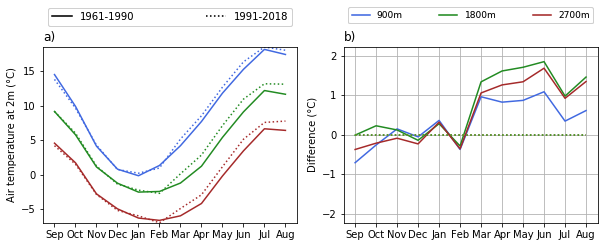

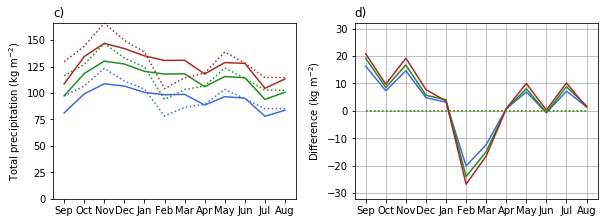

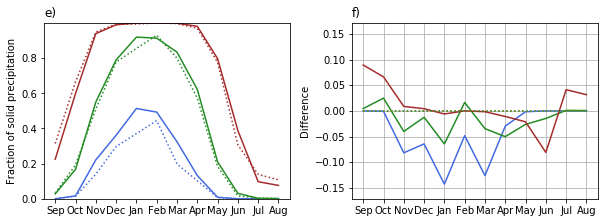

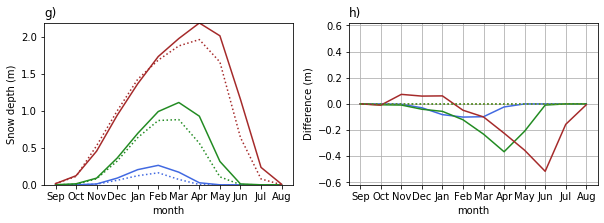

In [75]:
#############################
# Evolutions mensuelles S2M #
#############################

pp = PdfPages('/home/monteiro/Bureau/Rapport STAGE IENM3/distrib_mens_S2M.pdf')
letter = [['a)','b)'],['c)','d)'],['e)','f)'],['g)','h)']]

for j in range(0,len(all_var)):
    
    unit = all_unit[j]
    var_name = all_var[j]
    run = 'run_eval' #RCP85, HISTORICAL or run_eval/
    yr_1 = 1961
    yr_2 = 2018


    if var_name == all_var[2]:    
        s2m_month = calc_ratio_s2m(per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2)))
    else:
        s2m_month = per_alt_per_massif(calc_mean(load_ds_s2m(var_name),'month'),style = 'S2M').sel(year = slice(yr_1,yr_2))

    fig, ax = plt.subplots(1,2, figsize =(8.5,3.2))

    plot_ZS_range = np.arange(900,3600,900)
    color = ['royalblue','forestgreen', 'brown']

    # Define lim difference #
    diff_lim = []
    data_lim = []
    for i in range(0,len(plot_ZS_range)): 

        alt_i = plot_ZS_range[i]
        s2m_mean_1 = s2m_month.sel(ZS = alt_i ).mean(dim ='massif').sel(year = slice(1961,1990)).mean(dim = 'year')
        s2m_mean_2 = s2m_month.sel(ZS = alt_i).mean(dim = 'massif').sel(year = slice(1991,2018)).mean(dim = 'year')
        diff_lim.append(np.abs(s2m_mean_2 - s2m_mean_1))
        data_lim.append([s2m_mean_2, s2m_mean_1])
    diff_lim = np.nanmax(diff_lim)
    data_lim_inf = np.nanmin(data_lim)
    data_lim_sup = np.nanmax(data_lim)
    
    #########################

    for i in range(0,len(plot_ZS_range)):

        alt_i = plot_ZS_range[i]

        s2m_mean_1 = s2m_month.sel(ZS = alt_i ).mean(dim ='massif').sel(year = slice(1961,1990)).mean(dim = 'year')
        s2m_mean_2 = s2m_month.sel(ZS = alt_i).mean(dim = 'massif').sel(year = slice(1991,2018)).mean(dim = 'year')
        ax[0].plot(s2m_mean_2.month,s2m_mean_2, linestyle = ':',label = '1991-2018', color = color[i])
        ax[0].plot(s2m_mean_1.month,s2m_mean_1, linestyle = '-', label = '1961-1990', color = color[i])
        ax[0].set_ylim(data_lim_inf,data_lim_sup)
        ax[0].set_ylabel(var_name+unit)
        if var_name == all_var[3]:
            ax[0].set_xlabel('month')
        ax[0].set_title(letter[j][0] , loc = 'left')

        diff = (s2m_mean_2 - s2m_mean_1)
        ax[1].plot(diff.month,diff,linestyle = '-' ,color = color[i])
        ax[1].plot(diff.month,[0]*len(diff.month),  linestyle = ':')
        ax[1].set_ylabel('Difference'+unit)
        if var_name == all_var[3]:
            ax[1].set_xlabel('month')
        ax[1].set_ylim((-diff_lim*1.2, diff_lim*1.2))
        ax[1].set_title(letter[j][1] , loc = 'left')
        plt.grid()
        
    if j == 0 :
        lines = ax[0].get_lines()
        legend1 = ax[0].legend([Line2D([0],[0],color = 'k', linestyle = '-'),Line2D([0],[0],color = 'k', linestyle = ':')], ['1961-1990','1991-2018'],mode = 'expand',ncol = 4,bbox_to_anchor=(0., 1.15, 1., .102), prop={'size': 10})
        legend2 = ax[1].legend([lines[x] for x in [1,3,5]], ['900m','1800m','2700m'],mode = 'expand',ncol = 3,bbox_to_anchor=(0., 1.15, 1., .102), prop={'size': 9})
        ax[0].add_artist(legend1)
        ax[1].add_artist(legend2)
    if j == 1:
        ax[0].set_ylim((0, data_lim_sup))
    plt.tight_layout()
    plt.savefig(pp, format='pdf', bbox_inches='tight')
pp.close()

In [66]:
########################################
### Tableau recap des diff de climat ###
########################################

TABLE = []
ls_name = []

for k in range(0,len(all_var)):

    unit = all_unit[k]
    var_name = all_var[k]

    ##########################################################

    if var_name == all_var[2]:    
        s2m_clim_1961 = calc_ratio_s2m(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(),style = 'S2M').sel(ZS = [900,1800,2700]).sel(time = slice('1961','1990'))).mean(dim = ('time','massif'))
        s2m_clim_1991 = calc_ratio_s2m(per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(),style = 'S2M').sel(ZS = [900,1800,2700]).sel(time = slice('1991','2018'))).mean(dim = ('time','massif'))
    elif var_name == all_var[1]:
        s2m_clim_1961 = per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(),style = 'S2M').sel(ZS = [900,1800,2700]).sel(time = slice('1961','1990')).mean(dim = ('time','massif'))
        s2m_clim_1991 = per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').sum(),style = 'S2M').sel(ZS = [900,1800,2700]).sel(time = slice('1991','2018')).mean(dim = ('time','massif'))
 
    else:
        s2m_clim_1961 = per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').mean(),style = 'S2M').sel(ZS = [900,1800,2700]).sel(time = slice('1961','1990')).mean(dim = ('time','massif'))
        s2m_clim_1991 = per_alt_per_massif(load_ds_s2m(var_name).resample(time = '1Y').mean(),style = 'S2M').sel(ZS = [900,1800,2700]).sel(time = slice('1991','2018')).mean(dim = ('time','massif'))
    
    if var_name == all_var[0] or var_name == all_var[2]:
        diff = (s2m_clim_1991 - s2m_clim_1961)/3

    if var_name == all_var[1] or var_name == all_var[3]:
        diff = (((s2m_clim_1991 - s2m_clim_1961)/s2m_clim_1961)*100)/3
        
    diff = np.around(diff, decimals = 2)
        
    TABLE.append(diff)

TABLE = xr.concat(TABLE,dim = 'Variable')
TABLE['Variable'] = ['Air temperature at 2m (°C/dec)','Total precipitation (%/dec)','Fraction of solid precipitation (U/dec)', 'Snow depth (%/dec)']
TABLE = TABLE.rename({'ZS' : 'Elevation (m)'})

table = TABLE.to_dataset(name = '').to_dataframe()


In [67]:
display(Latex(table.to_latex()))

<IPython.core.display.Latex object>

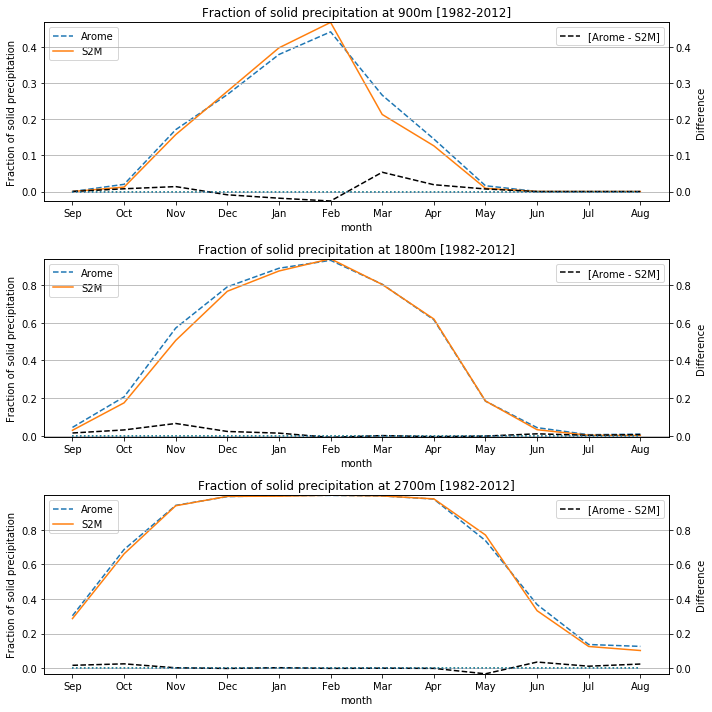

In [53]:
# # Evolutions mensuelles # Tout sur le meme graphe

# plt.figure(figsize=(10,10))
# plot_number = 1

# plot_ZS_range = np.arange(900,3600,900)

# for i in range(0,len(plot_ZS_range)):
    
#     alt_i = plot_ZS_range[i]
#     ax = plt.subplot(3, 1, plot_number)
#     ax1 = ax.twinx()
    
#     arome_mean = ar_month.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
#     s2m_mean = s2m_month.sel(ZS = alt_i).mean(dim = 'massif').mean(dim = 'year')
#     diff = (arome_mean - s2m_mean)
#     data = [arome_mean, s2m_mean, diff]

#     ax.plot(arome_mean.month,arome_mean, linestyle = '--',label = 'Arome')
#     ax.plot(s2m_mean.month,s2m_mean, linestyle = '-', label = 'S2M')
    
#     ax.set_ylim(np.nanmin(data),np.nanmax(data))
#     ax1.set_ylim(np.nanmin(data),np.nanmax(data))
#     if var_name == all_var[1]:
#         ax1.set_ylim(-100,100)
#     else:
#         ax.plot(arome_mean.month,[0]*len(arome_mean.month),  linestyle = ':')
#     ax1.plot(diff.month,diff,color = 'black',linestyle = '--' ,label = '[Arome - S2M]')
#     ax1.plot(arome_mean.month,[0]*len(arome_mean.month),  linestyle = ':')
#     ax1.set_ylabel('Difference'+unit)
#     ax.set_ylabel(var_name+unit)
#     ax.set_xlabel('month')
#     ax.legend(loc = 'upper left')
#     ax1.legend(loc = 'upper right')

#     ax.set_title(var_name+' at '+str(alt_i)+'m'+' ['+str(yr_1+1)+'-'+str(yr_2)+']')
    
#     plot_number = plot_number+1
#     plt.grid()
# plt.tight_layout()

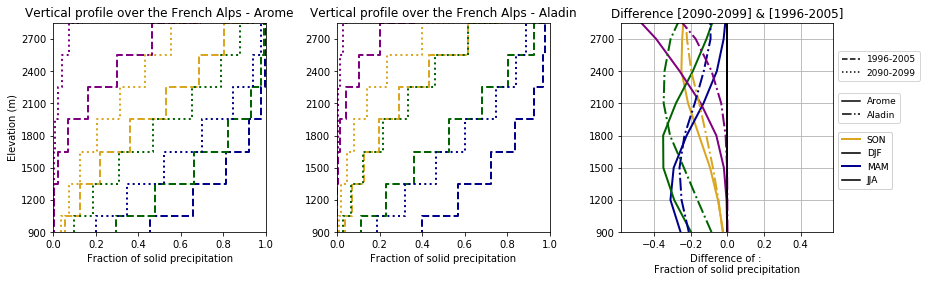

In [16]:
# ########################
# # PROFILS ALTITUDINAUX #
# ########################

# borne_alt = [900,3000]

# fig, ax = plt.subplots(1,3,figsize=(12,4))

# linestyle = ['--', ':']
# linestyle_2  = ['-','-','-.']
# color = ['goldenrod','darkblue','darkgreen','purple']


# data = [ar_season_hist.mean(dim = 'massif').sel(ZS = slice(borne_alt[0],borne_alt[1])),ar_season_RCP85.mean(dim = 'massif').sel(ZS = slice(borne_alt[0],borne_alt[1])), adam_season_hist.mean(dim = 'massif').sel(ZS = slice(borne_alt[0],borne_alt[1])), adam_season_RCP85.mean(dim = 'massif').sel(ZS = slice(borne_alt[0],borne_alt[1]))]

# for j in range(0,2):
#     x = data[j]
#     x_mean, x_std = x.mean(dim='year'), x.std(dim = 'year')

#     for i in range(0,len(x.season)):
#         ax[0].step(x_mean.sel(season = x.season[i]),x.ZS-150, where='pre', linestyle = linestyle[j],linewidth=2, color = color[i])
#         ax[0].set_ylabel('Elevation (m)')
#         ax[0].set_xlabel(var_name+unit)
#         ax[0].set_yticks(x.ZS)
#         ax[0].set_ylim(borne_alt[0],borne_alt[1]-150)
        
# for j in range(2,4):
#     x = data[j]
#     x = x.sel(ZS = slice(borne_alt[0],borne_alt[1]))
#     x_mean, x_std = x.mean(dim='year'), x.std(dim = 'year')

#     for i in range(0,len(x.season)):
#         ax[0+1].step(x_mean.sel(season = x.season[i]),x.ZS-150, where='pre', linestyle = linestyle[j-2],linewidth=2, color = color[i])
#         ax[0+1].set_xlabel(var_name+unit)
#         ax[0+1].set_yticks(x.ZS)
#         ax[0+1].set_ylim(borne_alt[0],borne_alt[1]-150)

# ax[0].set_xlim(np.nanmin(data), np.nanmax(data))
# ax[0+1].set_xlim(np.nanmin(data), np.nanmax(data))
# ax[0].set_title('Vertical profile over the French Alps - Arome')
# ax[0+1].set_title('Vertical profile over the French Alps - Aladin')


# for j in (0,2):
    
#     diff = data[j+1].mean(dim = 'year') - data[j].mean(dim = 'year')

#     for i in range(0,len(diff.season)):
#         ax[0+2].plot(diff.sel(season = diff.season[i]),diff.ZS,linestyle = linestyle_2[j], linewidth = 2, color = color[i])
#         ax[0+2].plot([0]*len(diff.ZS), diff.ZS, linestyle = '-', color = 'k')
#         ax[0+2].set_yticks(diff.ZS)
#         ax[0+2].set_xlabel('Difference of : \n'+var_name+unit)
#         ax[0+2].set_ylim(borne_alt[0],borne_alt[1]-150)
#         ax[0+2].set_title('Difference [2090-2099] & [1996-2005]')

# xlim = plt.xlim()
# max_xlim = max(map(abs, xlim))
# plt.xlim((-max_xlim, max_xlim))

# lines = ax[0+2].get_lines()
# legend3 = ax[0+2].legend([Line2D([0],[0],color = 'k', linestyle = linestyle[0]),Line2D([0],[0],color = 'k', linestyle = linestyle[1])], ['1996-2005', '2090-2099'], loc="lower left",bbox_to_anchor=(1, 0.7), prop={'size': 9})
# ax[0+2].add_artist(legend3)
# legend1 = ax[0+2].legend([Line2D([0],[0],color = 'k', linestyle = linestyle_2[0]),Line2D([0],[0],color = 'k', linestyle = linestyle_2[2])], ['Arome', 'Aladin'], loc="lower left",bbox_to_anchor=(1, 0.5), prop={'size': 9})
# ax[0+2].add_artist(legend1)
# legend2 = ax[0+2].legend([lines[k] for k in [0,1,2,3]], ['SON','DJF','MAM','JJA'], loc="upper left", bbox_to_anchor=(1, 0.5), prop={'size': 9})
# ax[0+2].add_artist(legend2)

# plt.tight_layout(pad=1, w_pad=0.1, h_pad=1.0)
# plt.grid()

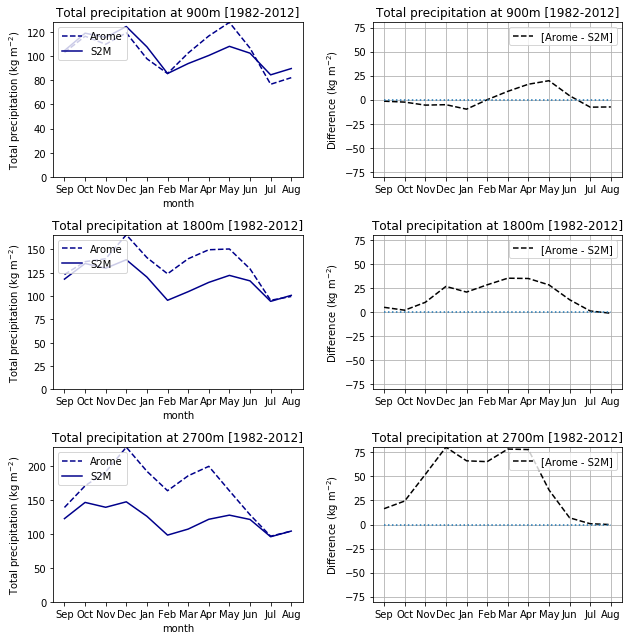

In [70]:
# # Evolutions mensuelles #

# plt.figure(figsize=(9,9))
# plot_number = 1

# plot_ZS_range = np.arange(900,3600,900)

# # Define lim difference #
# for i in range(0,len(plot_ZS_range)): 
#     diff_lim = []
#     alt_i = plot_ZS_range[i]
#     arome_mean = ar_month.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
#     s2m_mean = s2m_month.sel(ZS = alt_i).mean(dim = 'massif').mean(dim = 'year')
#     diff_lim.append(arome_mean - s2m_mean)
# diff_lim = np.nanmax(diff_lim)
# #########################

# for i in range(0,len(plot_ZS_range)):
    
#     alt_i = plot_ZS_range[i]
#     ax = plt.subplot(3, 2, plot_number)
    
#     arome_mean = ar_month.sel(ZS = alt_i ).mean(dim ='massif').mean(dim = 'year')
#     s2m_mean = s2m_month.sel(ZS = alt_i).mean(dim = 'massif').mean(dim = 'year')
#     data = [arome_mean, s2m_mean]
#     ax.plot(arome_mean.month,arome_mean, linestyle = '--',label = 'Arome', color = 'darkblue')
#     ax.plot(s2m_mean.month,s2m_mean, linestyle = '-', label = 'S2M', color = 'darkblue')
#     ax.set_ylim(0,np.nanmax(data))
#     ax.set_ylabel(var_name+unit)
#     ax.set_xlabel('month')
#     ax.legend(loc = 'upper left')
#     ax.set_title(var_name+' at '+str(alt_i)+'m'+' ['+str(yr_1+1)+'-'+str(yr_2)+']')

#     plot_number = plot_number+1
#     ax = plt.subplot(3, 2, plot_number)
    
#     diff = (arome_mean - s2m_mean)
#     ax.set_ylim(np.nanmin(data),np.nanmax(data))
#     ax.plot(diff.month,diff,color = 'black',linestyle = '--' ,label = '[Arome - S2M]')
#     ax.plot(arome_mean.month,[0]*len(arome_mean.month),  linestyle = ':')
#     ax.set_ylabel('Difference'+unit)
#     ax.legend(loc = 'upper right')
#     ax.set_title(var_name+' at '+str(alt_i)+'m'+' ['+str(yr_1+1)+'-'+str(yr_2)+']')

#     plt.ylim((-diff_lim, diff_lim))
    
#     plot_number = plot_number+1
#     plt.grid()
# plt.tight_layout()